In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import os
import random 
#import cv2
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import torch.utils.data
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import datetime
import time
from tqdm import tqdm

## TOC:
* [Dataset and basic CNN](#part1)
* [Save/Load Model](#part2)
* [Visualization of model](#part3)
* [Visualization of plain dataset](#part4)
* [EfficientNet](#part5)

In [2]:
transform = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
    ])

# Dataset and basic CNN <a class="anchor" id="part1"></a>

In [55]:
# import matplotlib.pyplot as plt
# x_data = torch.tensor(training_data2)
# x_labels = torch.tensor(training_labels)

#trainLoader = torch.utils.data.DataLoader(temp2, batch_size=100,
                                    #shuffle=True, num_workers=2)


writer = SummaryWriter()

traindir = "./train"
valdir = "./val"
testdir = "./test"


normalize = transforms.Normalize(mean=[0.485], std=[0.229])

traindata = torchvision.datasets.ImageFolder(traindir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((50,50)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),#augmenting data?
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))
valdata = torchvision.datasets.ImageFolder(valdir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((50,50)),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),#augmenting data?
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))
testdata = torchvision.datasets.ImageFolder(testdir,transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((50,50)),
        #transforms.CenterCrop(224),
        #transforms.RandomHorizontalFlip(),#augmenting data?
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),
       ]))

test_loader = torch.utils.data.DataLoader(testdata,batch_size=50, 
                                          shuffle=False)
train_loader = torch.utils.data.DataLoader(traindata,batch_size=50,
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(valdata,batch_size=50,
                                         shuffle=True)


In [4]:
class CNN(nn.Module):
    def __init__(self,activation_function):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 6, 3),#900x900 -> 898x898 (no pad)
            activation_function(),
            nn.MaxPool2d(2, stride = 2), #2x2 maxpool (devide hight and with by 2 -> 15x15)
            nn.Conv2d(6, 10, 3),#(no padding -> 13x13)
            activation_function()
            #nn.MaxPool2d(2, stride = 2)
        )
        self.linear_lay = nn.Sequential(
            nn.Linear(4840, 1000),# (13X13X10 (outchanels))
            activation_function(),
            nn.Linear(1000, 100),
            activation_function(),
            nn.Linear(100, 10),
            activation_function(),
            nn.Linear(10,2)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0),-1)# this flattens X before linear layer
        x = self.linear_lay(x) # bc this is our output layer. No activation here.
        
        return F.softmax(x, dim=1)

In [5]:
def test(model, loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for i, data in enumerate(tqdm(loader), 0):
            image, label = data
            pred = model(image)
            for i in label:
                if torch.argmax(pred[i]) == label[i]:
                    correct += 1
                total += 1
    print("The models accuracy is ", correct/total*100, "% of total ",total)

In [6]:
def validate(model, validationLoader):
    finalLoss = 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for i, data in enumerate(validationLoader, 0):
            image, label = data
            outputs = model(image)
            loss = criterion(outputs, label)
            finalLoss += loss
            
    return finalLoss/(i+1)

In [7]:
def train_model(model, loss_function, optimizer, loader, val_loader, nr_epochs, log_name, scheduler=None):
    for epoch in range(nr_epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        for i, data in enumerate(tqdm(loader), 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            train_loss += loss.item()

        val_loss = validate(model, val_loader)

        print('[Epoch %d] Train loss: %.4f Val loss: %.4f' %
              (epoch + 1, train_loss / i, val_loss))

        writer.add_scalars(log_name, {
            'train_loss': train_loss/i,
            'val_loss': val_loss,
        }, epoch)
        
        if scheduler:
            scheduler.step()

In [45]:
Normal_CNN20 = CNN(nn.LeakyReLU)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(Normal_CNN20.parameters(), lr=0.0001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

train_model(Normal_CNN20, loss_function, optimizer, train_loader, val_loader, 20, "Normal_CNN50", scheduler)

[Epoch 1] Train loss: 0.5327 Val loss: 0.6546
[Epoch 2] Train loss: 0.4013 Val loss: 0.6077
[Epoch 3] Train loss: 0.3821 Val loss: 0.6503
[Epoch 4] Train loss: 0.3723 Val loss: 0.5590
[Epoch 5] Train loss: 0.3715 Val loss: 0.6136
[Epoch 6] Train loss: 0.3642 Val loss: 0.5890
[Epoch 7] Train loss: 0.3625 Val loss: 0.5489
[Epoch 8] Train loss: 0.3605 Val loss: 0.6277
[Epoch 9] Train loss: 0.3564 Val loss: 0.5506
[Epoch 10] Train loss: 0.3562 Val loss: 0.5797
[Epoch 11] Train loss: 0.3540 Val loss: 0.5670
[Epoch 12] Train loss: 0.3515 Val loss: 0.6684
[Epoch 13] Train loss: 0.3505 Val loss: 0.6278
[Epoch 14] Train loss: 0.3501 Val loss: 0.5581
[Epoch 15] Train loss: 0.3500 Val loss: 0.5752
[Epoch 16] Train loss: 0.3477 Val loss: 0.7000
[Epoch 17] Train loss: 0.3478 Val loss: 0.6573
[Epoch 18] Train loss: 0.3488 Val loss: 0.6430
[Epoch 19] Train loss: 0.3469 Val loss: 0.7003
[Epoch 20] Train loss: 0.3465 Val loss: 0.6102


KeyboardInterrupt: 

In [93]:
test(Normal_CNN20, test_loader) #Note that the Normal_CNN50 is only trained for 20

The models accuracy is  75.0 % of total  624
The models accuracy is  71.47435897435898 % of total  624


## Save/Load Model <a class="anchor" id="part2"></a>

In [59]:
torch.save(Normal_CNN20.state_dict(), "./models/Normal_CNN20")

In [8]:
Normal_CNN20 = CNN(nn.LeakyReLU)
Normal_CNN20.load_state_dict(torch.load("./models/Normal_CNN20"))
Normal_CNN20.eval()

CNN(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 10, kernel_size=(3, 3), stride=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
  )
  (linear_lay): Sequential(
    (0): Linear(in_features=4840, out_features=1000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1000, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=10, out_features=2, bias=True)
  )
)

## Visualization of model <a class="anchor" id="part3"></a>

In [67]:
X = []
Y = []
with torch.no_grad():
    for i, data in enumerate(  , 0):
        image, label = data
        cnn_x = Normal_CNN50.conv(image)
        X = cnn_x.view(cnn_x.size(0),-1)# this flattens X before linear layer
        Y = label
        break
     
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_2d = tsne.fit_transform(X)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.001s...
[t-SNE] Computed neighbors for 50 samples in 0.010s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 6.748592
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.199200
[t-SNE] KL divergence after 300 iterations: 0.713133


In [68]:
copy_untrained_data = X
pca = PCA(n_components=2, svd_solver='full')
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)

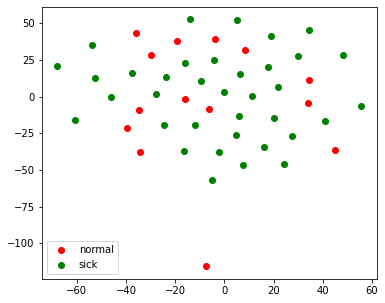

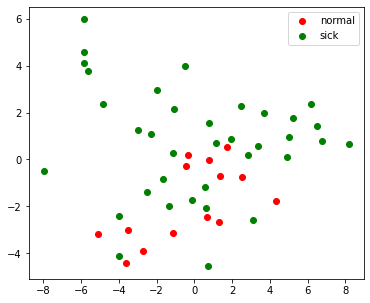

In [69]:
numbers=["normal","sick"]


plt.figure(figsize=(6, 5))
colors = 'r', 'g'
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_2d[Y == i, 0], X_2d[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_untrained_PCA[Y == i, 0], X_untrained_PCA[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()


## Visualization of plain dataset <a class="anchor" id="part4"></a>

In [16]:
X = []
Y = []

for i, data in enumerate(test_loader, 0):
    image, label = data    
    X=image
    
    print(image.shape)
    Y=label
    print(Y)
    break
    
X=X.view(-1, 10000)
print(X.shape)
print(Y.shape)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
X_2d = tsne.fit_transform(X)


torch.Size([50, 1, 50, 50])
tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
        1, 1])


RuntimeError: shape '[-1, 10000]' is invalid for input of size 125000

In [28]:
copy_untrained_data = X
pca = PCA(n_components=2, svd_solver='full')
pca.fit(copy_untrained_data)
X_untrained_PCA = pca.transform(copy_untrained_data)


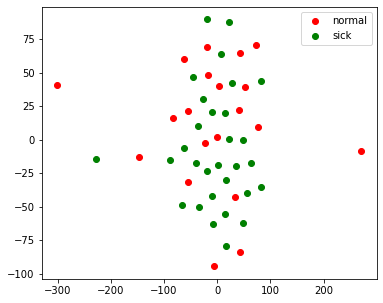

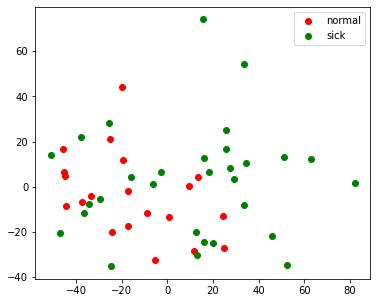

In [29]:
numbers=["normal","sick"]


plt.figure(figsize=(6, 5))
colors = 'r', 'g'
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_2d[Y == i, 0], X_2d[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()

plt.figure(figsize=(6, 5))
for i, c, label in zip(range(0,2), colors, numbers):
    plt.scatter(X_untrained_PCA[Y == i, 0], X_untrained_PCA[Y == i, 1], c=c, label=label)
plt.legend()
plt.show()


# EfficientNet <a class="anchor" id="part5"></a>

In [1]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16447 sha256=8ed31a7a9dd7ce772aa7141fdbd88c0e13e6ada49c6a7162289f56f97e268345
  Stored in directory: c:\users\alexc\appdata\local\pip\cache\wheels\84\b9\90\25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [9]:
from efficientnet_pytorch import EfficientNet
effinet = EfficientNet.from_name('efficientnet-b0')

In [10]:
for param in effinet.parameters():
    param.requires_grad = False
    
effinet._fc = nn.Sequential(
            nn.Linear(1280, 500),
            nn.LeakyReLU(),
            nn.Linear(500, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 2),
            nn.Softmax(dim=1)
        )

effinet._conv_stem = nn.Conv2d(
    1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
  )

In [11]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(effinet.parameters(), lr=0.0001)

decayRate = 0.96
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

train_model(effinet, loss_function, optimizer, train_loader, val_loader, 30, "EfficientNet", scheduler)

  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 1] Train loss: 0.5849 Val loss: 0.6135


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 2] Train loss: 0.5260 Val loss: 0.6641


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 3] Train loss: 0.5195 Val loss: 0.7262


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 4] Train loss: 0.5184 Val loss: 0.6399


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 5] Train loss: 0.5179 Val loss: 0.6976


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 6] Train loss: 0.5161 Val loss: 0.6702


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 7] Train loss: 0.5160 Val loss: 0.5524


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 8] Train loss: 0.5139 Val loss: 0.6253


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 9] Train loss: 0.5094 Val loss: 0.6416


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 10] Train loss: 0.5126 Val loss: 0.6556


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 11] Train loss: 0.5134 Val loss: 0.6326


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 12] Train loss: 0.5104 Val loss: 0.5017


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 13] Train loss: 0.5110 Val loss: 0.5662


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 14] Train loss: 0.5137 Val loss: 0.5978


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 15] Train loss: 0.5107 Val loss: 0.6209


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 16] Train loss: 0.5090 Val loss: 0.6811


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 17] Train loss: 0.5088 Val loss: 0.6317


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 18] Train loss: 0.5095 Val loss: 0.6229


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 19] Train loss: 0.5088 Val loss: 0.6590


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 20] Train loss: 0.5101 Val loss: 0.6967


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 21] Train loss: 0.5048 Val loss: 0.5670


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 22] Train loss: 0.5060 Val loss: 0.6260


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 23] Train loss: 0.5059 Val loss: 0.5962


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 24] Train loss: 0.5069 Val loss: 0.5393


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 25] Train loss: 0.5062 Val loss: 0.5748


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 26] Train loss: 0.5108 Val loss: 0.6714


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 27] Train loss: 0.5066 Val loss: 0.5597


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 28] Train loss: 0.5042 Val loss: 0.5467


  0%|                                                                                          | 0/105 [00:00<?, ?it/s]

[Epoch 29] Train loss: 0.5004 Val loss: 0.5923


100%|████████████████████████████████████████████████████████████████████████████████| 105/105 [04:00<00:00,  2.29s/it]


[Epoch 30] Train loss: 0.5032 Val loss: 0.5855


In [12]:
test(effinet, test_loader)
test(Normal_CNN20, test_loader)

  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

The models accuracy is  91.50641025641025 % of total  624


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:13<00:00,  1.02s/it]

The models accuracy is  57.85256410256411 % of total  624


In [13]:
torch.save(effinet.state_dict(), "./models/effinet30")

In [14]:
test(effinet, test_loader)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:20<00:00,  1.56s/it]

The models accuracy is  63.62179487179487 % of total  624


In [50]:
test(effinet, test_loader)
test(effinet, test_loader)
test(effinet, test_loader)
test(effinet, test_loader)


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

The models accuracy is  51.92307692307693 % of total  624


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

The models accuracy is  50.641025641025635 % of total  624


  0%|                                                                                           | 0/13 [00:00<?, ?it/s]

The models accuracy is  43.91025641025641 % of total  624


100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:39<00:00,  3.02s/it]

The models accuracy is  43.91025641025641 % of total  624


In [59]:
for z in range(20):
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            image, label = data
            pred = effinet(image)
            #plt.title("Predicted: "+str(torch.argmax(pred[0]).item())+"\tTrue: "+str(label[0].item()))
            #plt.imshow(trans(image[0]).convert("RGB"))
            #plt.show()
            print(torch.argmax(pred[0]) == label[0])
            
            if torch.argmax(pred[0]) == label[0]:
                true_img = image[0]
            else:
                false_img = image[0]
            break;
    

tensor(False)
tensor(False)
tensor(False)
tensor(True)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)
tensor(False)


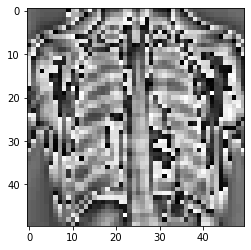

In [60]:
plt.imshow(trans(true_img).convert("RGB"))

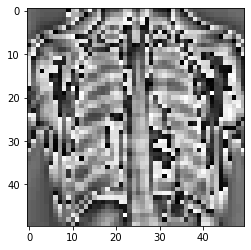

In [61]:
plt.imshow(trans(false_img).convert("RGB"))

In [76]:
for x in range(len(true_img[0])):
    for y in range(len(true_img[0][0])):
        if true_img[0][x][y] != false_img[0][x][y]:
            print("NOT SAME AT <"+str(x)+", "+str(y)+">")